# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.

In [2]:
#standard width is ~60%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import norm
import matplotlib as mpl
import yfinance as yf
import math
import json
import datetime as DT
from scipy import optimize

In [4]:
import logging
logger = logging.getLogger('yfinance')
logger.disabled = True
logger.propagate = False

# In this project, we will set up a "high risk" and "low risk" portfolio, it's on us to define these terms   


   
# We start with the least risky:
- The goal here will be to get all stock data from the past two years, sort by volume and cut to 200 stocks, sort by volatility and cut to 100 stocks
- Then, we have developed a search algorithm that should come up with a very low correlated portfolo in a short amount of time
- For demonstration we will pick 10 stocks to create the portfolio, then optimize the weights for minimal variance again
- This should be close to the least risky you can have, and will most likely be profitable. If not profitable, we can incorporate an intermediate step where we sort by log returns

## First, we'll need NASDAQ tickers

In [5]:
absolute_path_to_tickers = '/home/travis/Documents/Reseach/Quant_Prep/Stock_Utilities'
nasdaq_json = absolute_path_to_tickers+'/Nasdaq.json'

with open(nasdaq_json, 'r') as data_file:
    nasdaq_data = data_file.read()

nasdaq_tickers = np.array(json.loads(nasdaq_data))

In [6]:
# DOWNLOAD ALL TICKER DATA FROM LAST 2 YEARS
tickers = [nasdaq_tickers[i]['Symbol'] for i in range(len(nasdaq_tickers))]
start = DT.datetime.today() -  DT.timedelta(days = 2*365)
end = DT.datetime.today() -  DT.timedelta(days = 365)


ALL_ASSETS = yf.download(tickers, start=start, end=end)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4944 of 4944 completed


In [7]:
NA_dropped = ALL_ASSETS.drop(ALL_ASSETS.tail(1).index).dropna(axis=1)
%reset_selective ALL_ASSETS

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Take the first 200, ordered by mean volume. We only care about log returns now.

In [8]:
mean_volume = NA_dropped['Volume'].mean()
# sort will by defaults ascend least to greatest, but we want greatest to least so "ascending=False"
sorted_tickers = mean_volume.sort_values(ascending=False).index

log_returns = np.log(NA_dropped['Close'] / NA_dropped['Close'].shift(1))
volume_sorted_log_returns = log_returns[sorted_tickers[0:200]].dropna()

/home/travis/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


## Now we sort by volatility, averaged over the entire two years. Take the smallest 100

In [9]:
volatility = volume_sorted_log_returns.std()
tickers_by_volatility = volatility.sort_values().index
sorted_volatility = volume_sorted_log_returns[tickers_by_volatility[0:100]]

## Find the Pearson covariance matrix and find its abs(minimum)

In [10]:
COV_MAT = sorted_volatility.cov()
abs_cov = COV_MAT.abs()
# Use idxmin twice to get the location of the minimum
col = abs_cov.min().idxmin()
row = abs_cov[col].idxmin()
min_val = COV_MAT.at[row, col]

print(f"Minimum covariance is between {row} and {col}: {min_val:.4f}")
initial_labels = [row,col]

Minimum covariance is between PDBC and SHY: 0.0000


## Now, we find a chain of covariances which minimize the existing covariances in the chain   
This doesn't necessarily find the minimum, but it should be somewhat close for our purposes

In [11]:
def total_variance_in_quadrature(cov_df, labels):
    """Compute total variance by summing all variances + covariances in quadrature"""
    sub_cov = cov_df.loc[labels, labels]
    total_var = sub_cov.to_numpy().sum()
    return total_var

In [12]:
selected_labels = initial_labels.copy()

while len(selected_labels) < 50:
    remaining_labels = [lbl for lbl in COV_MAT.columns if lbl not in selected_labels]
    best_label = None
    best_var = np.inf

    for candidate in remaining_labels:
        trial_labels = selected_labels + [candidate]
        var = total_variance_in_quadrature(COV_MAT, trial_labels)
        if var < best_var:
            best_var = var
            best_label = candidate

    selected_labels.append(best_label)

final_safe_log_returns = sorted_volatility[selected_labels]
final_COV = final_safe_log_returns.cov()

## With the chain of variances found, we can put our portfolio together to find its conglomerate return and covariance

In [13]:
conglomerate_log_returns = final_safe_log_returns.mean(axis=1)
total_log_returns = round(np.sum(conglomerate_log_returns),6)
print(f"Total Annualized log returns:  {total_log_returns*np.sqrt(252)}")
n_assets = final_COV.shape[0]
equal_weights = np.array([1/n_assets] * n_assets)
var_vec = np.matmul(equal_weights,final_COV)
total_var = np.dot(equal_weights,var_vec)
print(f"Equally Weighted Anualized Volatility Sum: {np.sqrt(total_var*252)}")

Total Annualized log returns:  1.4297851745097934
Equally Weighted Anualized Volatility Sum: 0.07856155088167861


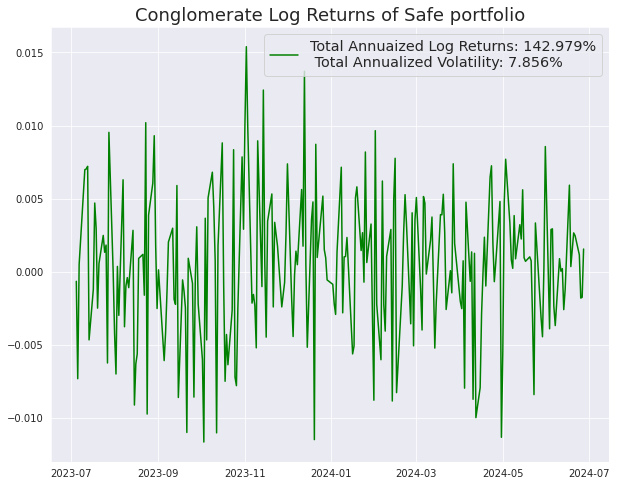

In [14]:
fig,ax = plt.subplots(figsize=(10,8))
c = "g" if total_log_returns > 0 else "r" if total_log_returns < 0 else "k"

ax.plot(conglomerate_log_returns,color=c,label="Total Annuaized Log Returns: {:.3f}%\n Total Annualized Volatility: {:.3f}%".format(total_log_returns*np.sqrt(252)*100,np.sqrt(total_var*252)*100))
ax.legend(fontsize='x-large')
ax.set_title(r"Conglomerate Log Returns of Safe portfolio",size=18)
plt.show()

In [15]:
assets = list(final_safe_log_returns.columns.values)
print("ASSETS IN SAFE PORTFOLIO ARE: ", assets)

ASSETS IN SAFE PORTFOLIO ARE:  ['PDBC', 'SHY', 'VCSH', 'IGSB', 'BNDX', 'QYLD', 'BND', 'TMUS', 'VCIT', 'IBKR', 'IEF', 'PEP', 'ARCC', 'PFF', 'FAST', 'EMB', 'KDP', 'CSCO', 'MSFT', 'KHC', 'ORLY', 'PAA', 'AZN', 'CTSH', 'AAPL', 'FOXA', 'MDLZ', 'TLT', 'ACWI', 'CSX', 'GILD', 'BKR', 'NFLX', 'XEL', 'CMCSA', 'QQQ', 'EXC', 'WDC', 'VOD', 'MNST', 'VTRS', 'SBUX', 'TSCO', 'DBX', 'AEP', 'NVDA', 'APA', 'DXCM', 'GRAB', 'MCHI']


## Not bad!

# Now moving on to the risky protfolio

## Here, we'll take a slightly different strategy since we stand to take on extra risk, we will stand to make more return. However, we don't wan't to expose ourselves to too much risk. Therefore, we will again sort by Volume, and then sort by RETURN. Then, we will find the weights which maximize the Sharpe Ratio.

In [24]:
N = 25

In [25]:
# we already have volume_sorted_log_returns
mean_returns = volume_sorted_log_returns.mean(axis=0)
tickers_by_return = mean_returns.sort_values(ascending=False).index
sorted_returns = volume_sorted_log_returns[tickers_by_return[0:N]]
mean_returns_cut = sorted_returns.mean(axis=0)
COV_mat = sorted_returns.cov()

In [26]:
mean_returns_cut

Ticker
NVDL    0.006895
MSTR    0.005627
SMCI    0.005135
CLSK    0.004809
VKTX    0.004800
APP     0.004699
NVDA    0.004327
DJT     0.004298
COIN    0.004155
CRWD    0.003935
OCGN    0.003759
ASTS    0.003625
IBRX    0.003508
FEMY    0.003424
WULF    0.003148
HOOD    0.003028
IREN    0.002959
MU      0.002956
WDC     0.002774
ARDX    0.002733
AFRM    0.002566
PDD     0.002482
ALT     0.002482
TQQQ    0.002469
AVGO    0.002464
dtype: float64

In [27]:
COV_mat

Ticker,NVDL,MSTR,SMCI,CLSK,VKTX,APP,NVDA,DJT,COIN,CRWD,...,HOOD,IREN,MU,WDC,ARDX,AFRM,PDD,ALT,TQQQ,AVGO
Ticker,,,,,,,,,,,,,,,,,,,,,
NVDL,0.002610,0.000681,0.001761,0.000663,0.000199,0.000495,0.001427,-0.000073,0.000731,0.000610,...,0.000290,0.000529,0.000640,0.000477,0.000209,0.000206,0.000303,0.000114,0.001002,0.000717
MSTR,0.000681,0.003252,0.000866,0.002243,0.000960,0.000259,0.000363,0.000375,0.001823,0.000406,...,0.000888,0.001913,0.000288,0.000168,0.000181,0.000809,0.000153,0.000671,0.000478,0.000182
SMCI,0.001761,0.000866,0.003486,0.000878,0.000338,0.000501,0.000982,0.000317,0.000682,0.000533,...,0.000356,0.000593,0.000569,0.000459,0.000498,0.000420,0.000201,0.000235,0.000899,0.000708
CLSK,0.000663,0.002243,0.000878,0.004937,0.001068,0.000673,0.000373,0.000567,0.002197,0.000469,...,0.001116,0.003534,0.000337,0.000154,0.000642,0.001273,0.000373,0.001627,0.000645,0.000275
VKTX,0.000199,0.000960,0.000338,0.001068,0.004981,0.000260,0.000113,0.000540,0.000706,0.000290,...,0.000588,0.000494,0.000165,0.000228,0.000865,0.000650,-0.000030,0.001772,0.000256,0.000096
APP,0.000495,0.000259,0.000501,0.000673,0.000260,0.001284,0.000275,0.000400,0.000466,0.000287,...,0.000349,0.000303,0.000208,0.000173,0.000280,0.000500,0.000147,0.000308,0.000440,0.000192
NVDA,0.001427,0.000363,0.000982,0.000373,0.000113,0.000275,0.000794,-0.000024,0.000412,0.000341,...,0.000164,0.000309,0.000353,0.000267,0.000122,0.000143,0.000180,0.000070,0.000576,0.000401
DJT,-0.000073,0.000375,0.000317,0.000567,0.000540,0.000400,-0.000024,0.006916,0.000258,0.000160,...,0.000235,-0.000136,0.000121,0.000095,0.000307,0.000736,-0.000111,0.000232,0.000055,0.000007
COIN,0.000731,0.001823,0.000682,0.002197,0.000706,0.000466,0.000412,0.000258,0.002227,0.000437,...,0.000892,0.001874,0.000278,0.000204,0.000316,0.001139,0.000266,0.000823,0.000556,0.000212


## According to the website below, the bond rate over the past 2 years is about 3.7%
https://ycharts.com/indicators/2_year_treasury_rate
## We'll need this for the Sharpe ratio

In [28]:
def SharpeRatio(weight_vec,mu_vec,Cov_mat,r=0.037):
    mu_tot = np.dot(mu_vec,weight_vec)
    Cov_tot = np.matmul(Cov_mat,weight_vec)
    Cov_tot = np.matmul(weight_vec,Cov_tot)
    return (mu_tot - r)/Cov_tot

## Optimize sharpe ratio under constraints, e.g. we don't want to put more than 35% of our capital into a stock. Let's also only invest, no shorting or negative contributions

In [29]:
n_assets = COV_mat.shape[0]
initial_weights = np.array([1/n_assets] * n_assets)
assets = sorted_returns.columns.values

constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
              {'type': 'ineq', 'fun': lambda weights: .35-max(weights)},
              {'type': 'ineq', 'fun': lambda weights: -weights})

result = optimize.minimize(SharpeRatio, initial_weights, constraints = constraints, args = (mean_returns_cut.values,COV_mat.values))
optimal_weights = result.x

print("Optimal Asset Weights to minimize variance:")
for asset, weight in zip(assets, optimal_weights):
    print(f"{asset}: Weight = {weight:.4f}")

Optimal Asset Weights to minimize variance:
NVDL: Weight = 0.0399
MSTR: Weight = 0.0373
SMCI: Weight = 0.0393
CLSK: Weight = 0.0337
VKTX: Weight = 0.0391
APP: Weight = 0.0425
NVDA: Weight = 0.0429
DJT: Weight = 0.0417
COIN: Weight = 0.0378
CRWD: Weight = 0.0425
OCGN: Weight = 0.0410
ASTS: Weight = 0.0389
IBRX: Weight = 0.0390
FEMY: Weight = 0.0378
WULF: Weight = 0.0336
HOOD: Weight = 0.0410
IREN: Weight = 0.0357
MU: Weight = 0.0434
WDC: Weight = 0.0440
ARDX: Weight = 0.0412
AFRM: Weight = 0.0390
PDD: Weight = 0.0444
ALT: Weight = 0.0386
TQQQ: Weight = 0.0420
AVGO: Weight = 0.0438


## So what do the returns of this portfolio look like?

In [30]:
Risky_Portfolo = sorted_returns * optimal_weights

conglomerate_log_returns = Risky_Portfolo.mean(axis=1)
total_log_returns = round(np.sum(conglomerate_log_returns),6)
print(f"Total Annualized log returns:  {total_log_returns*np.sqrt(252)}")
total_var = np.matmul(COV_mat,optimal_weights)
total_var = np.matmul(optimal_weights,total_var)
print(f"Equally Weighted Anualized Volatility Sum: {np.sqrt(total_var*252)}")

Total Annualized log returns:  0.5831024229481473
Equally Weighted Anualized Volatility Sum: 0.3819702292992416


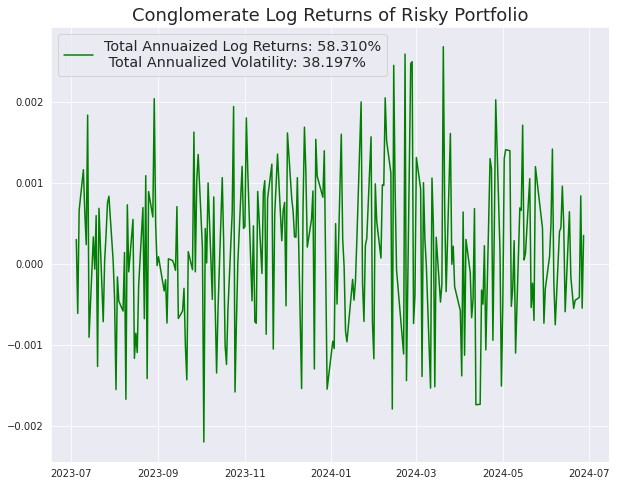

In [31]:
fig,ax = plt.subplots(figsize=(10,8))
c = "g" if total_log_returns > 0 else "r" if total_log_returns < 0 else "k"

ax.plot(conglomerate_log_returns,color=c,label="Total Annuaized Log Returns: {:.3f}%\n Total Annualized Volatility: {:.3f}%".format(total_log_returns*np.sqrt(252)*100,np.sqrt(total_var*252)*100))
ax.legend(fontsize='x-large')
ax.set_title(r"Conglomerate Log Returns of Risky Portfolio",size=18)
plt.show()

## Definitely more volatile, but actually ended up worse with returns! 